Comandos GIT para facilitar interagir com o repositório

In [ ]:
!git clone https://github.com/gcerbaro/DSFinal_global_cancer_patients.git
%cd DSFinal_global_cancer_patients
#!git pull


Cloning into 'DSFinal_global_cancer_patients'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 32 (delta 6), reused 22 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 1.20 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/DSFinal_global_cancer_patients


In [ ]:
import pandas as pd
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

'\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import r2_score'

In [ ]:
df = pd.read_csv("./dataset/global_cancer_patients_2015_2024.csv")
df.head(5)

,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,PT0000000,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65
2,PT0000002,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84
3,PT0000003,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12
4,PT0000004,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62


Limpeza e normalização dos dados


Unique Values for each non-numeric column:

Gender:
['Male' 'Female' 'Other']


Country_Region:
['UK' 'China' 'Pakistan' 'Brazil' 'Germany' 'Canada' 'USA' 'India'
 'Australia' 'Russia']


Cancer_Type:
['Lung' 'Leukemia' 'Breast' 'Colon' 'Skin' 'Cervical' 'Prostate' 'Liver']


Cancer_Stage:
['Stage III' 'Stage 0' 'Stage II' 'Stage I' 'Stage IV']


Year:
[2021 2023 2015 2017 2018 2022 2016 2024 2020 2019]




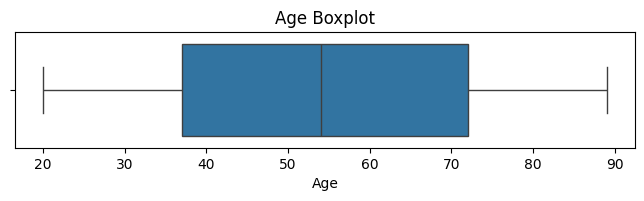

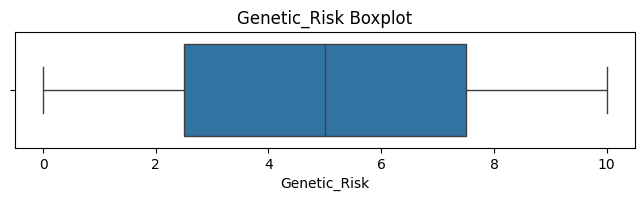

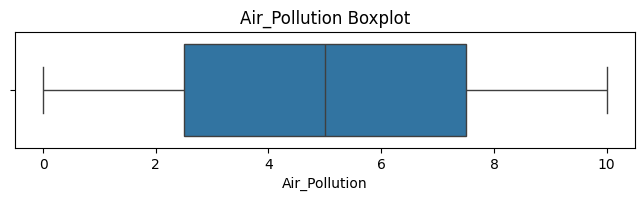

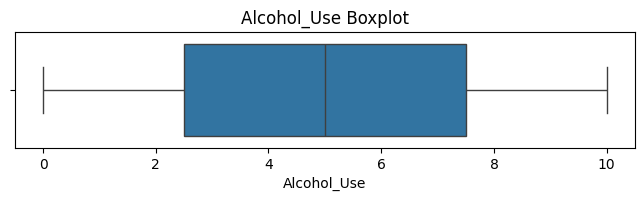

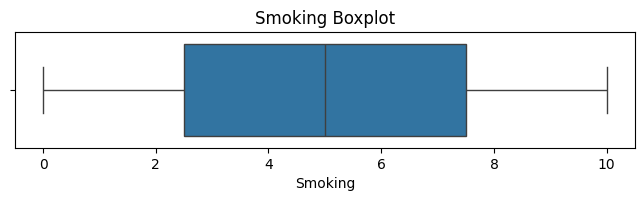

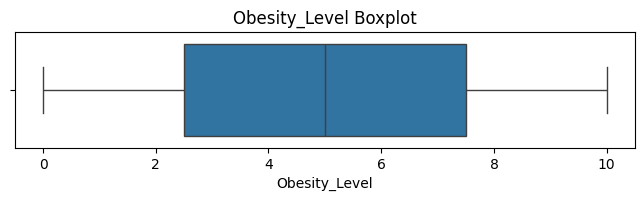

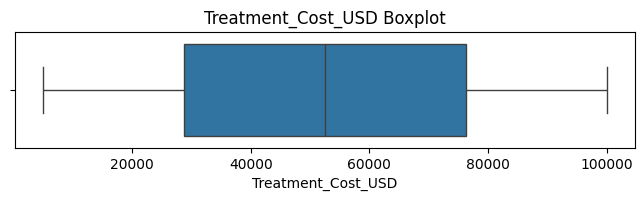

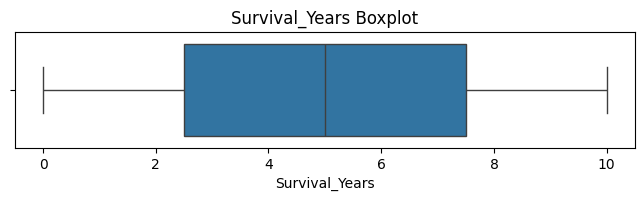

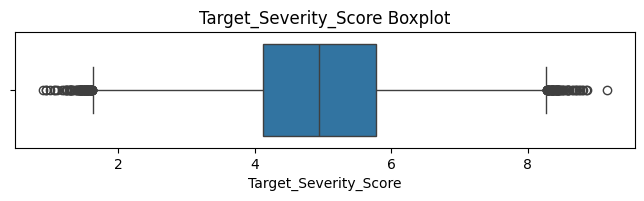

0 Outlier values removed from 'Age'
0 Outlier values removed from 'Genetic_Risk'
0 Outlier values removed from 'Air_Pollution'
0 Outlier values removed from 'Alcohol_Use'
0 Outlier values removed from 'Smoking'
0 Outlier values removed from 'Obesity_Level'
0 Outlier values removed from 'Treatment_Cost_USD'
0 Outlier values removed from 'Survival_Years'
151 Outlier values removed from 'Target_Severity_Score'


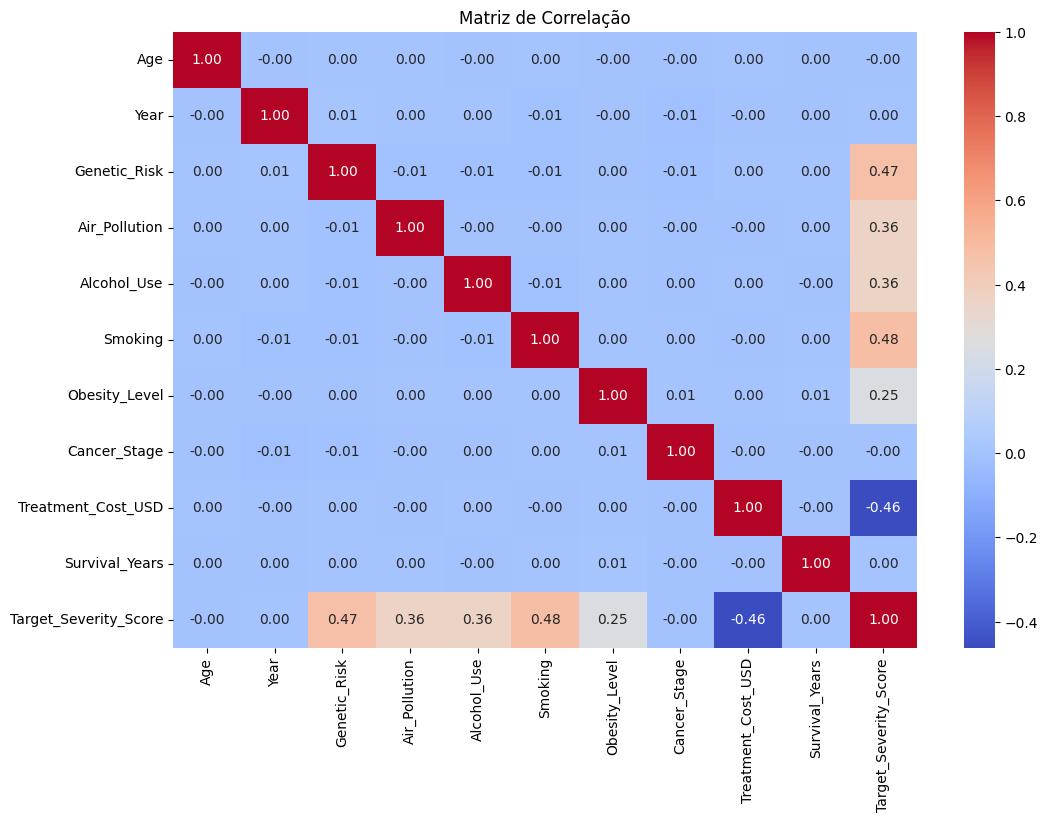

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


#Limpeza de valores nulos, duplicados e exclusao da coluna ID
df = df.dropna()
df = df.drop_duplicates()
df = df.drop(columns=['Patient_ID'])

'''
ESSA PARTE AQUI PRA BAIXO PODE TIRAR
'''

#Verificacao de valores unicos
print("\nUnique Values for each non-numeric column:\n")
df_temp = df.select_dtypes(exclude=['number'])
df_temp['Year'] = df['Year']
for c in df_temp.columns:
    print(f"{c}:")
    print(df[c].unique())
    print('\n')


# Remocao de valores irreais para propria descricao do dataset
# Pessoa não pode ter sobrevivido mais do que sua idade
df = df[df["Survival_Years"] <= df["Age"]]


#Conversao de valores textuais para numericos
# Uso de One-Hot Encoding para variaveis nominais e map para variavel ordinal em sequencia

#Estagio do cancer
cancer_stage_map = {
    'Stage 0': 0,
    'Stage I': 1,
    'Stage II': 2,
    'Stage III': 3,
    'Stage IV': 4
}

df = pd.get_dummies(df, columns=[
    'Gender', 'Country_Region', 'Cancer_Type'], drop_first=True)
df['Cancer_Stage'] = df['Cancer_Stage'].map(cancer_stage_map)


# Visualizacao dos dados numeros na busca por outliers
df_numeric_cols = df.select_dtypes(include=['int64', 'float64'])
df_numeric_cols = df_numeric_cols.drop(columns=['Year', 'Cancer_Stage'])

'''
ESSA EXIBICAO DE GRAFICOS AQUI TAMBEM PODE TIRAR
USEI PRA VISUALIZAR OS OUTLIERS
Se quiser deixar tambem fica bala
'''
for col in df_numeric_cols:
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(data=df, x=col)
    plt.title(f'{col} Boxplot')
    plt.show()


# Remocao dos outliers baseado no IQR
def clear_outliers(c):
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    df_limpo = df[(df[c] >= lower_limit) & (df[c] <= upper_limit)]

    print(f"{df.shape[0] - df_limpo.shape[0]} Outlier values removed from '{c}'")
    return df_limpo


for c in df_numeric_cols:
    df = clear_outliers(c)


# Normalizacao dos dados com MixMaxScaler
# Transforma dados numeros entre valores de 0 a 1
scaler = MinMaxScaler()

for c in df_numeric_cols:
    df[c] = scaler.fit_transform(df[[c]])

df


import seaborn as sns
import matplotlib.pyplot as plt

df_temp = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = df_temp.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()



Random Forest Regression

In [ ]:
X = df.drop(columns=['Target_Severity_Score'])
y = df['Target_Severity_Score']

# Divisão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliação
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')


Mean Squared Error: 0.0007
R² Score: 0.9778
